# Captone Project Submission

Please fill out:
* Student name: Wesley Yu
* Student pace: Flex
* Scheduled project review date/time: May 03, 2023 / 3:30 PM
* Instructor name: Abhineet Kulkarni
* Blog post URL:https://github.com/whyyoutoo/Sentiment_Classification_for_Amazon_Product_Reviews

# Sentiment Classification

Instead of using an unsupervised method like VADER for sentiment analysis, I will create a model that will try to predict the sentiment of a review with supervised learning methods.

In [1]:
# the usuals
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for preserving tokens when reading csv file
from ast import literal_eval

# vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# classifiers
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# ultils and metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# text preprocessing
import spacy
import contractions
import re

# plotting word vectors
from sklearn.manifold import TSNE

from wordcloud import WordCloud

In [2]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [3]:
data = pd.read_csv('data/processed_reviews.csv', converters = {'cleaned_text': literal_eval})

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133546 entries, 0 to 133545
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviews         133546 non-null  object
 1   sentiment       133546 non-null  object
 2   cleaned_text    133546 non-null  object
 3   dominant_topic  133546 non-null  object
dtypes: object(4)
memory usage: 4.1+ MB


In [5]:
data.head()

,reviews,sentiment,cleaned_text,dominant_topic
0,"Get the SportaPros instead. They look better,...",Positive,"[instead, look, well, wear, street, configurat...",Comfort
1,I've been looking for a lighter alternative to...,Positive,"[look, light, alternative, absolutely, perfect...",Sound Quality
2,The finest headphones available. You can spend...,Positive,"[fine, headphone, available, spend, vast, amou...",Sound Quality
3,3rd pair of these I've purchased. My wife has...,Positive,"[pair, purchase, wife, pair, pair, glove, box,...",Customer Service
4,My old Koss Porta Pros finally got beat to dea...,Positive,"[old, finally, get, beat, death, year, ago, la...",Comfort


In [6]:
data.sentiment.value_counts(normalize = True)

Positive    0.766582
Negative    0.233418
Name: sentiment, dtype: float64

## Text Cleaning for sentiment analysis

I will need to modify the text cleaning process for sentiment analysis. Negation words such as not and no are usually removed by standard stop word lists. These negations may not have made a big difference for topic modeling, but they can change the sentiment of a statement depending on if they are removed or not. For example the phrase "Not great, do not buy" is a negative statement. But after removal of standard stop words the statment will be "great buy", which can be seen as positive.

In [7]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [8]:
len(stop_words)

326

In [9]:
# list for words to remove from stop_words
stop_list = ['cannot', 'not', 'nor', 'no']

In [10]:
for item in stop_list:
    # Add the word to the set of stop words.
    nlp.Defaults.stop_words.remove(item)
    
    # Set the stop_word tag on the lexeme
    nlp.vocab[item].is_stop = False

In [11]:
len(stop_words)

322

Another step I will be adding is to expand conractions. This will allow me to preserve 'not' tokens. For this i will be using the contractions library that expands contractions with below simple code.

In [12]:
contractions.fix('wont cant dont')

'will not cannot do not'

In [13]:
def clean_text(text):
    # Replace &nbsp; with regular space
    text = text.replace("&nbsp;", " ")
    # Remove HTML tags and attributes
    text = re.sub(r"<[^>]+>", "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove line breaks and extra whitespace
    text = re.sub(r"\s+", " ", text)
    # Expand contractions
    text = contractions.fix(text)
    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase and remove leading/trailing white space
    # Tokenize and lemmatize, keep words with length greater than 1
    doc = nlp(text)
    lemmas = [token.lemma_.lower().strip() for token in doc if not token.is_punct and not token.is_stop and len(token) > 1]
    
    return lemmas

In [14]:
# sample review to test clean function
data.reviews[132512]

"I got these headphones as a xmas for my wife (yeah for me too). I own multiple pairs of corded headphones and one other pair of cheap bluetooth headphones (Kinivo BTH240). My daily go to headphones are a pair of Sennheiser hd 280 pro cans and I have a pair of Audio-Technica ATH-M30 that I use at work.\n\nRatings:\n\nSound: 8/10\n\nThe sound is fairly detailed and well balanced. The bass end is not overpowering nor underwhelming. Midrange is clear and distinct. High end has detail and it is not too tinny. YMMV. I would say, for the headphones I use, the sound reproduction is somewhere between my Audio-Technica ATH-M30 but not quite as good as my Sennheiser hd 280. Which is on par for the price range they are in. Come on people, stop comparing these to headphones that cost 3-5 times as much.\n\nComfort: 10/10\n\nThese fit over my ears well and these may very well be the most comfortable headphones I presently own. Most headphones I wear do not bother me much and these are no exception.\

In [15]:
clean_text(data.reviews[132512])

['get',
 'headphone',
 'xma',
 'wife',
 'yeah',
 'multiple',
 'pair',
 'cord',
 'headphone',
 'pair',
 'cheap',
 'bluetooth',
 'headphone',
 'kinivo',
 'bth',
 'daily',
 'headphone',
 'pair',
 'sennheiser',
 'hd',
 'pro',
 'can',
 'pair',
 'audiotechnica',
 'athm',
 'use',
 'work',
 'ratings',
 'sound',
 'sound',
 'fairly',
 'detailed',
 'balance',
 'bass',
 'end',
 'not',
 'overpower',
 'nor',
 'underwhelme',
 'midrange',
 'clear',
 'distinct',
 'high',
 'end',
 'detail',
 'not',
 'tinny',
 'ymmv',
 'headphone',
 'use',
 'sound',
 'reproduction',
 'audiotechnica',
 'athm',
 'not',
 'good',
 'sennheiser',
 'hd',
 'par',
 'price',
 'range',
 'come',
 'people',
 'stop',
 'compare',
 'headphone',
 'cost',
 'time',
 'comfort',
 'fit',
 'ear',
 'comfortable',
 'headphone',
 'presently',
 'headphone',
 'wear',
 'not',
 'bother',
 'no',
 'exception',
 'build',
 'quality',
 'headphone',
 'solid',
 'feel',
 'lot',
 'like',
 'high',
 'end',
 'benz',
 'car',
 'door',
 'time',
 'tell',
 'durable',

In [16]:
data['cleaned_text_sent'] = data.reviews.apply(lambda x: clean_text(x))

In [17]:
#data.to_csv('data/cleaned_reviews.csv', index = False)

## Feature Engineering

Since my features are text data, before I can input into any models I will need to vectorize the text to be represented as numbers. I will test out various vectorizers and classification models to find the best performing model. 

Vectorizers:
* CountVectorizer
* TfidfVectorizer
* Word2Vec
* Pre-trained Glove

Classification Algorithms:
* Logistic Regression
* Naive Bayes
* Random Forest

## Data Preprocessing

Seperating target and features

In [18]:
# Changing sentiment to numerical values
data.replace({'sentiment':{'Negative': 0, 'Positive': 1}}, inplace = True)

In [19]:
data.sentiment

0         1
1         1
2         1
3         1
4         1
         ..
133541    1
133542    1
133543    1
133544    1
133545    1
Name: sentiment, Length: 133546, dtype: int64

### Train Test Split

Splitting data to train and test sets with stratify to keep class percentages similar in both.

In [20]:
X = data.cleaned_text_sent
y = data.sentiment

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    stratify = y,
                                                    random_state = 42)

In [22]:
X_train.shape

(106836,)

In [23]:
X_test.shape

(26710,)

In [24]:
y_train.value_counts(normalize = True)

1    0.766586
0    0.233414
Name: sentiment, dtype: float64

In [25]:
y_test.value_counts(normalize = True)

1    0.766567
0    0.233433
Name: sentiment, dtype: float64

## Baseline Model

During EDA I used VADER to validate sentiment with star ratings. It seems fitting that I should use it as a baseline model and see if supervised approaches can do better than VADER's unsupervised method.

In [26]:
sia = SentimentIntensityAnalyzer()

In [27]:
# create function to join tokens back into string
def join_tokens(tokens):
    tokens = " ".join(tokens)
    return tokens

In [28]:
vader_train = X_train.copy()

In [29]:
vader_train = vader_train.apply(join_tokens)

In [30]:
vader_train

63430     headphone arrive no trouble get connected lapt...
119628    great pair wireless earbud pros great running ...
113802    headphone gold standard noise cancelation no q...
56327     get good one comfortable awhile know able wear...
23581     fairly easy install sort mechanical know sure ...
                                ...                        
16539     purchase year old daughter long plane ride fit...
59025     great look thin case fit make phone look you b...
101352    work exactly describe stick desk not space hol...
13630     buy earbud exorbitantly price appreciate quali...
124505    excited get sound great fit perfect ear comfor...
Name: cleaned_text_sent, Length: 106836, dtype: object

In [31]:
vader_test = y_train.copy()

In [32]:
# use VADER's compund score as predictions
vader_pred = vader_train.apply(lambda x: sia.polarity_scores(str(x))['compound'])

In [33]:
vader_pred

63430     0.8225
119628    0.9524
113802   -0.2286
56327     0.9432
23581     0.8360
           ...  
16539     0.9742
59025     0.8706
101352    0.9186
13630     0.9474
124505    0.9042
Name: cleaned_text_sent, Length: 106836, dtype: float64

In [34]:
y_train

63430     1
119628    1
113802    1
56327     1
23581     1
         ..
16539     1
59025     1
101352    1
13630     1
124505    0
Name: sentiment, Length: 106836, dtype: int64

In [35]:
# make predictions binary
def make_binary(preds):
    if preds <=0:
        return 0
    else:
        return 1

In [36]:
vader_pred = vader_pred.apply(make_binary)

In [37]:
vader_pred

63430     1
119628    1
113802    0
56327     1
23581     1
         ..
16539     1
59025     1
101352    1
13630     1
124505    1
Name: cleaned_text_sent, Length: 106836, dtype: int64

In [38]:
accuracy_score(y_train, vader_pred)

0.8057583586057134

In [39]:
# creating dataframe to store results
model_results = pd.DataFrame(columns=['Model', 'mean f1_score', 'std f1_score', 'mean precision', 'mean recall'])

In [40]:
vader_f1 = f1_score(y_train, vader_pred, average = 'macro')
vader_precision = precision_score(y_train, vader_pred, average = 'macro')
vader_recall = recall_score(y_train, vader_pred, average = 'macro')

In [41]:
model_results = model_results.append({'Model': 'Baseline_vader',
                      'mean f1_score': round(vader_f1, 4),
                      'std f1_score': 'N/A',
                      'mean precision': round(vader_precision, 4),
                      'mean recall': round(vader_recall, 4)}, ignore_index = True)

In [42]:
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565


Baseline model perform decently. Since I am working with an imbalanced dataset and what to treat both classes equally. I will be focusing on macro metrics. I will choose to observed f1_macro, precision_macro and recall_macro scores between different algorithms.

### Count Vectorizer

Vectorizer used to create a bag of words model. Will create a matrix will all the words avaliable in the documents and the number of times they appear.

In [43]:
def dummy(doc):
    return doc

In [44]:
# Instantiate CountVectorizer with unigrams and bigrams
count_vect = CountVectorizer(ngram_range = (1,2), 
                             stop_words = None, 
                             tokenizer = dummy, 
                             preprocessor = dummy,
                             min_df = 10)

In [45]:
count_vect.fit(X_train)

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(min_df=10, ngram_range=(1, 2),
                preprocessor=<function dummy at 0x0000027BF5CC5940>,
                tokenizer=<function dummy at 0x0000027BF5CC5940>)

In [46]:
# Total vocabulary length
len(count_vect.get_feature_names())

64601

#### Logistic Regression

In [47]:
# instantiate classifier, class weights set to balanced for imbalanced dataset
logr = LogisticRegression(class_weight = 'balanced', 
                          # solver set to saga for larger dataset
                          solver = 'saga', 
                          max_iter = 1000,
                          random_state = 42,
                          n_jobs = -1)

In [48]:
# making pipeline for vectorizer and classifier
cv_logr_model = Pipeline([
    ('countvec', count_vect),
    ('logr', logr)
])

In [49]:
# running cross validation
cv_logr = cross_validate(cv_logr_model, X_train, y_train, cv = 5, 
                         scoring = ['f1_macro', 'precision_macro', 'recall_macro'])

In [50]:
model_results = model_results.append({'Model': 'cv_logr_model',
                      'mean f1_score': round(cv_logr['test_f1_macro'].mean(), 4),
                      'std f1_score': round(cv_logr['test_f1_macro'].std(), 4),
                      'mean precision': round(cv_logr['test_precision_macro'].mean(), 4),
                      'mean recall': round(cv_logr['test_recall_macro'].mean(), 4)}, ignore_index = True)

In [51]:
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532


Much better results than baseline. f1 score of 84% was obtained. High scores for precision and recall are also observed. 

In [ ]:
# plotting confusion matrix with cross_val_predict, this method uses vales that matches closer to cross validated scores
cv_logr_hat = cross_val_predict(cv_logr_model, X_train, y_train, cv = 5)

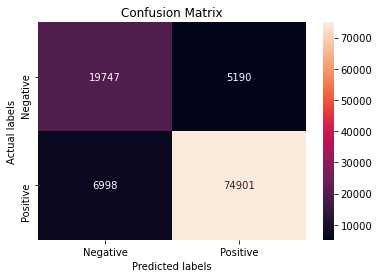

In [121]:
cm = confusion_matrix(y_train, cv_logr_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

Examining the confusion matrix, this model has predicted 19,747 reviews correctly as negative and 74,901 reviews correctly as positive. There were 5,190 false positives and 6,998 false negatives predicted. Since this model performed much better than the baseline, I will compare other models' metrics to this one. The aim is to see if we can lower both FP and FN errors while maintaining high TP and TN.

#### Naive Bayes

In [53]:
# class_prior set to ratio of target classes to help with class imbalance
mnb = MultinomialNB(class_prior = [0.23, 0.77])

In [54]:
cv_mnb_model = Pipeline([
    ('countvec', count_vect),
    ('mnb', mnb)
])

In [55]:
cv_mnb = cross_validate(cv_mnb_model, X_train, y_train, cv = 5, 
                        scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'cv_mnb_model',
                      'mean f1_score': round(cv_mnb['test_f1_macro'].mean(), 4),
                      'std f1_score': round(cv_mnb['test_f1_macro'].std(), 4),
                      'mean precision': round(cv_mnb['test_precision_macro'].mean(), 4),
                      'mean recall': round(cv_mnb['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441


Naive Bayes was not able to perform better than baseline. It was able to compute predictions much faster though.

In [ ]:
cv_mnb_hat = cross_val_predict(cv_mnb_model, X_train, y_train, cv = 5)

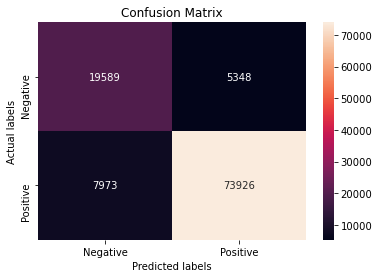

In [122]:
cm = confusion_matrix(y_train, cv_mnb_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

From the confusion matrix we can see that both FP and FN are greater than cv_logr_model. FP 5,348 vs 5,190 and FN 7,973 vs 6,998 as well as lower TN and TP. 

#### Random Forest

In [57]:
rf = RandomForestClassifier(class_weight = 'balanced', random_state=42, n_jobs = -1)

In [58]:
cv_rf_model = Pipeline([
    ('countvec', count_vect),
    ('rf', rf)
])

In [59]:
cv_rf = cross_validate(cv_rf_model, X_train, y_train, cv = 5, 
                       scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'cv_rf_model',
                      'mean f1_score': round(cv_rf['test_f1_macro'].mean(), 4),
                      'std f1_score': round(cv_rf['test_f1_macro'].std(), 4),
                      'mean precision': round(cv_rf['test_precision_macro'].mean(), 4),
                      'mean recall': round(cv_rf['test_recall_macro'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
3,cv_rf_model,0.7974,0.0029,0.8771,0.7602


Random Forest performed lower than cv_logr_model when comparing f1 score. Precision was observed to be higher at 87%.

In [ ]:
cv_rf_hat = cross_val_predict(cv_rf_model, X_train, y_train, cv = 5)

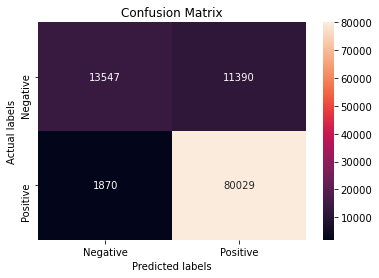

In [123]:
cm = confusion_matrix(y_train, cv_rf_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

This model predicted positive sentiment better with more TP 80,029 vs 74,901 and less FN 1,870 vs 6,998. However it suffered white predicting negative sentiment with more FP 11,390 vs 5,190 and less TN 13,547 vs 19,747. Comparing models by macro f1 score, will hopefully strike a balance between precision and recall where we can obtain the highest TP and TN, while keeping FP and FN low.

### TF-IDF

One way to focus on more meaningful terms is to use TF-IDF Vectorizer. TF-IDF scores give more importance to terms that appear frequently in a certain document, but less frequent in all other documents. TF-IDF scores will be lower for words that appear frequently in all documents.

In [61]:
tfidf = TfidfVectorizer(ngram_range = (1,2), 
                             stop_words = None, 
                             tokenizer = dummy, 
                             preprocessor = dummy,
                             min_df = 10)

In [62]:
tfidf.fit(X_train)

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=10, ngram_range=(1, 2),
                preprocessor=<function dummy at 0x0000027BF5CC5940>,
                tokenizer=<function dummy at 0x0000027BF5CC5940>)

In [63]:
# Total vocabulary length
len(tfidf.get_feature_names())

64601

Total vocabulary similar to count vectorizer.

#### Logistic Regression

In [64]:
tfidf_logr_model = Pipeline([
    ('tfidfvec', tfidf),
    ('logreg', logr)
])

In [65]:
tfidf_logr = cross_validate(tfidf_logr_model, X_train, y_train, cv = 5, 
                            scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'tfidf_logr_model',
                      'mean f1_score': round(tfidf_logr['test_f1_macro'].mean(), 4),
                      'std f1_score': round(tfidf_logr['test_f1_macro'].std(), 4),
                      'mean precision': round(tfidf_logr['test_precision_macro'].mean(), 4),
                      'mean recall': round(tfidf_logr['test_recall_macro'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
3,cv_rf_model,0.7974,0.0029,0.8771,0.7602
4,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689


TF-IDF vectorizer shows an improvment over countvectorizer, achieving a higher recall score of 87% and a tiny improvment in f1 score.

In [ ]:
tfidf_logr_hat = cross_val_predict(tfidf_logr_model, X_train, y_train, cv = 5)

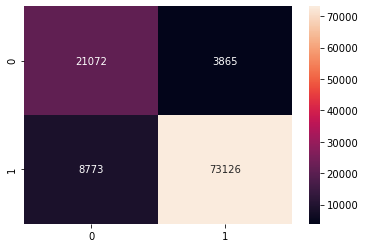

In [66]:
cm = confusion_matrix(y_train, tfidf_logr_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

This model performs slightly better than cv_logr_model in predicting negative sentiment with TN 21,072 vs 19,747 and less FP 3,865 vs 5,190. It did suffer a bit from predicting positive sentiment with FN 8,773 vs 6,998 and TP 73,126 vs 74,901. However I will choose this model over cv_logr_model because in this situation I would place more importance on the negative class. Having the model predict negative sentiment better, will give us more insight on what actions to take. I will proceed to compare future models' metrics to this model and see if any performs better.

#### Naive Bayes

In [67]:
tfidf_mnb_model = Pipeline([
    ('tfidfvec', tfidf),
    ('mnb', mnb)
])

In [68]:
tfidf_mnb = cross_validate(tfidf_mnb_model, X_train, y_train, cv = 5, 
                           scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'tfidf_mnb_model',
                      'mean f1_score': round(tfidf_mnb['test_f1_macro'].mean(), 4),
                      'std f1_score': round(tfidf_mnb['test_f1_macro'].std(), 4),
                      'mean precision': round(tfidf_mnb['test_precision_macro'].mean(), 4),
                      'mean recall': round(tfidf_mnb['test_recall_macro'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
3,cv_rf_model,0.7974,0.0029,0.8771,0.7602
4,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
5,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976


TF-IDF with NB performed poorly compared to previous model.

In [ ]:
tfidf_mnb_hat = cross_val_predict(tfidf_mnb_model, X_train, y_train, cv = 5)

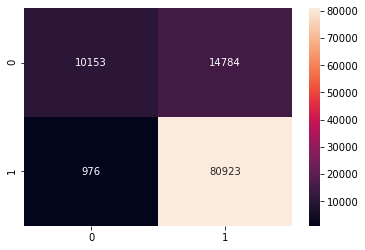

In [69]:
cm = confusion_matrix(y_train, tfidf_mnb_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

This model was able to predict positive sentiment better with higher TP 80,923 vs 73,126 and lower FN with 976 vs 8773. However it suffered significantly predicting negative sentiment with lower TN 10,153 vs 21,072 and higher FP 14,784 vs 3,865.

#### Random Forest

In [70]:
tfidf_rf_model = Pipeline([
    ('tfidfvec', tfidf),
    ('rf', rf)
])

In [71]:
tfidf_rf = cross_validate(tfidf_rf_model, X_train, y_train, cv = 5, 
                          scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'tfidf_rf_model',
                      'mean f1_score': round(tfidf_rf['test_f1_macro'].mean(), 4),
                      'std f1_score': round(tfidf_rf['test_f1_macro'].std(), 4),
                      'mean precision': round(tfidf_rf['test_precision_macro'].mean(), 4),
                      'mean recall': round(tfidf_rf['test_recall_macro'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
3,cv_rf_model,0.7974,0.0029,0.8771,0.7602
4,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
5,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
6,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580


Similar results to TF-IDF with NB, both these models are predicting more positive classes than negative.

In [ ]:
tfidf_rf_hat = cross_val_predict(tfidf_rf_model, X_train, y_train, cv = 5)

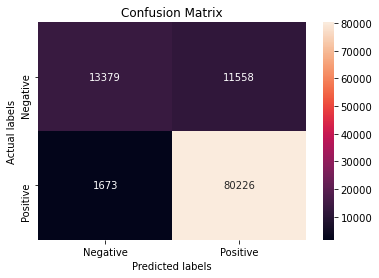

In [124]:
cm = confusion_matrix(y_train, tfidf_rf_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

Better than tfidf_mnb_model but still worse than our most optimal. Predicting better positive sentiment with lower FN 1,673 vs 8,773 and higher TP 80,226 vs 73,126, but worse negative sentiment with lower TN 13,379 vs 21,072 and higher FP 11,558 vs 3,865

### Word Embeddings

The previous two vectorization strategies have only focused on term frequency. In order to try to capture semantic meaning of terms, we can use word embeddings. Using Word2Vec we can create word vector embeddings that can try to capture semantic relationships between words, if given enough data to train on.

In [73]:
# creating a w2v model
model = Word2Vec(X_train, size=100, window=5, min_count=1, workers=4)

In [74]:
# total reviews in train set
model.corpus_count

106836

In [75]:
# train model
model.train(X_train, total_examples=model.corpus_count, epochs=10)

(37522428, 44748080)

In [76]:
# get word vectors
wv = model.wv

In [77]:
wv.most_similar('great')

[('good', 0.8174915313720703),
 ('excellent', 0.7883455753326416),
 ('fantastic', 0.7735345959663391),
 ('awesome', 0.7395637631416321),
 ('amazing', 0.6907590627670288),
 ('nice', 0.6734168529510498),
 ('perfect', 0.6648367643356323),
 ('decent', 0.645942211151123),
 ('wonderful', 0.6290574669837952),
 ('terrific', 0.6215558648109436)]

In [78]:
# Total vocabulary created 
len(wv.index2word)

63198

In [79]:
len(wv.vectors)

63198

In [80]:
# create a dictionary of words and vectors to plug into vectorizer pipeline
w2v = dict(zip(wv.index2word, wv.vectors))

Word vectors with a total vocabulary of 63,198 has been created. Less than previous vectorizers, this may be due to the inclusion of bigrams previously. We can check to see how well model is by checking similar words found by the model.

In [81]:
# testing w2v model by checking simlar word groupings

sample = ['feel', 'good', 'product', 'cheap', 'bad', 'great','price']

# loop through sample list and grab the top 5 most similar words
similar_words = {word: [item[0] for item in wv.most_similar([word], topn=5)]
                  for word in sample}
similar_words


{'feel': ['feeling', 'plasticy', 'squeeze', 'material', 'construction'],
 'good': ['decent', 'great', 'excellent', 'well', 'amazing'],
 'product': ['item', 'company', 'seller', 'vendor', 'supplier'],
 'cheap': ['expensive', 'cheaply', 'cheep', 'flimsy', 'cheapo'],
 'bad': ['terrible', 'horrible', 'poor', 'good', 'suck'],
 'great': ['good', 'excellent', 'fantastic', 'awesome', 'amazing'],
 'price': ['cost', 'dollar', 'pricing', 'pricepoint', 'msrp']}

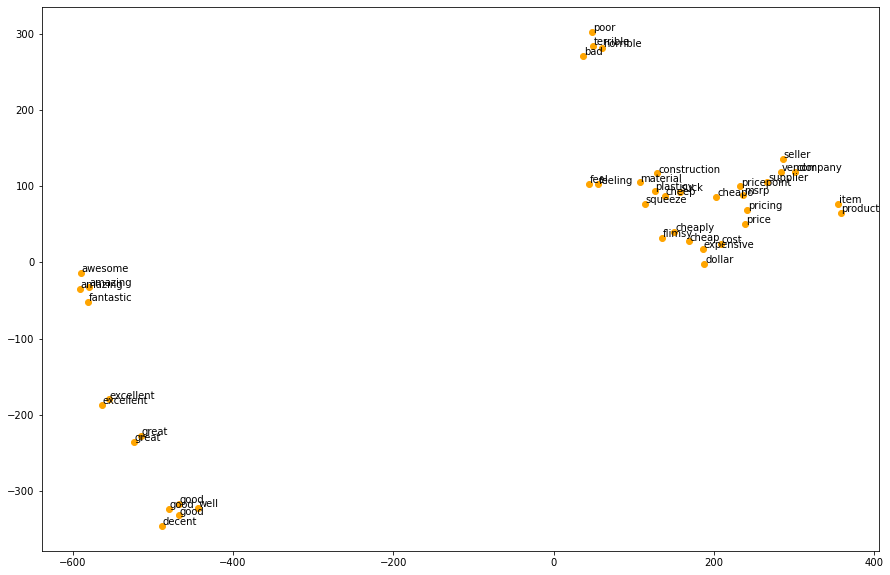

In [82]:
# concatenate sample and similar words
labels = sum([[k] + v for k, v in similar_words.items()], [])

# get vectors of all words
vec = wv[labels]

# reduce dimensionality of vectors to plot them
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(vec)

fig, ax = plt.subplots(figsize = (15,10))

ax.scatter(T[:, 0], T[:, 1], c='orange')

# label points
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    ax.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points', fontsize = 10)

Vectors created by w2v looks sensible. Words from our similar words search group together and are distinct from other groupings. Words similar to good are far away from words similar to bad.

#### Mean Word embeddings

To make use of these individual word vectors for classification, we can compute the mean word embedding for each document. Basically we can take all the vectors represented by each word in a document and average them together in one single vector representing the document. This can help reduce dimensionality of features and make algorithms faster to execute.

In [83]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

Naive Bayes does not take negative values for input, which some vectors created will have. I will skip MNB() classifer for these next steps to save some time on my part.

#### Logistic Regression with Word2Vec

In [84]:
w2v_logr_model = Pipeline([
    ('w2v', W2vVectorizer(w2v)),
    ('logr', logr)
])

w2v_logr = cross_validate(w2v_logr_model, X_train, y_train, cv = 5, 
                          scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'w2v_logr_model',
                      'mean f1_score': round(w2v_logr['test_f1_macro'].mean(), 4),
                      'std f1_score': round(w2v_logr['test_f1_macro'].std(), 4),
                      'mean precision': round(w2v_logr['test_precision_macro'].mean(), 4),
                      'mean recall': round(w2v_logr['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
3,cv_rf_model,0.7974,0.0029,0.8771,0.7602
4,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
5,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
6,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580
7,w2v_logr_model,0.7873,0.0019,0.7683,0.8298


Compared to baseline model, w2v with logistic regression placed more emphasis on the negative class. Resulting in a greater amount of false negatives.

In [ ]:
w2v_logr_hat = cross_val_predict(w2v_logr_model, X_train, y_train, cv = 5)

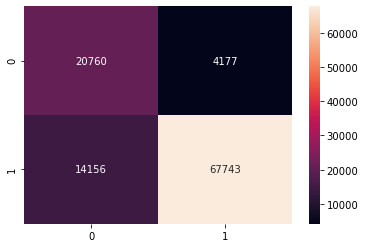

In [85]:
cm = confusion_matrix(y_train, w2v_logr_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

This model performed worse overall, with higher FP, FN and lower TP, TN.

#### Random Forest with Word2Vec

In [86]:
w2v_rf_model = Pipeline([
    ('w2v', W2vVectorizer(w2v)),
    ('rf', rf)
])

w2v_rf = cross_validate(w2v_rf_model, X_train, y_train, cv = 5, 
                        scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'w2v_rf_model',
                      'mean f1_score': round(w2v_rf['test_f1_macro'].mean(), 4),
                      'std f1_score': round(w2v_rf['test_f1_macro'].std(), 4),
                      'mean precision': round(w2v_rf['test_precision_macro'].mean(), 4),
                      'mean recall': round(w2v_rf['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
3,cv_rf_model,0.7974,0.0029,0.8771,0.7602
4,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
5,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
6,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580
7,w2v_logr_model,0.7873,0.0019,0.7683,0.8298
8,w2v_rf_model,0.7264,0.0032,0.8454,0.6909


This model also performed poorly compared to baseline model.

In [ ]:
w2v_rf_hat = cross_val_predict(w2v_rf_model, X_train, y_train, cv = 5)

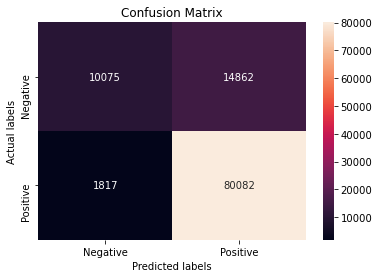

In [125]:
cm = confusion_matrix(y_train, w2v_rf_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

Similar to the performance of previous random forest models. This model predicts positive sentiment well with 80,082 TP and 1,817 FN, but suffers at predicting negative sentiment with only 10,075 TN and 14,862 FP.

#### Pre-trained word vectors with GloVe

Instead of training word embeddings, we can make use of weights from models that have been trained on massive amounts of text data. One popular model is GloVe, which has been trained on text data from wikipedia.

In [88]:
# find total vocabulary of train set
total_vocabulary = set(word for review in X_train for word in review)

In [89]:
len(total_vocabulary)

63198

In [90]:
# get appropriate vectors from GloVe file, using 100 dimension vectors
glove = {}
with open('data/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [91]:
glove['great']

array([-0.013786 ,  0.38216  ,  0.53236  ,  0.15261  , -0.29694  ,
       -0.20558  , -0.41846  , -0.58437  , -0.77355  , -0.87866  ,
       -0.37858  , -0.18516  , -0.128    , -0.20584  , -0.22925  ,
       -0.42599  ,  0.3725   ,  0.26077  , -1.0702   ,  0.62916  ,
       -0.091469 ,  0.70348  , -0.4973   , -0.77691  ,  0.66045  ,
        0.09465  , -0.44893  ,  0.018917 ,  0.33146  , -0.35022  ,
       -0.35789  ,  0.030313 ,  0.22253  , -0.23236  , -0.19719  ,
       -0.0053125, -0.25848  ,  0.58081  , -0.10705  , -0.17845  ,
       -0.16206  ,  0.087086 ,  0.63029  , -0.76649  ,  0.51619  ,
        0.14073  ,  1.019    , -0.43136  ,  0.46138  , -0.43585  ,
       -0.47568  ,  0.19226  ,  0.36065  ,  0.78987  ,  0.088945 ,
       -2.7814   , -0.15366  ,  0.01015  ,  1.1798   ,  0.15168  ,
       -0.050112 ,  1.2626   , -0.77527  ,  0.36031  ,  0.95761  ,
       -0.11385  ,  0.28035  , -0.02591  ,  0.31246  , -0.15424  ,
        0.3778   , -0.13599  ,  0.2946   , -0.31579  ,  0.4294

In [92]:
len(glove)

26555

Only 26,555 word vectors were found from GloVe. This could be due to the fact that I have not cleaned my text enough. There may be mispelled words or non sensible text as a result from my cleaning process. I will continue testing classifiers with these pre-trained words vectors, however I belive results will not be as great due to lower dimensionality of features.

#### Logistic Regression with GloVe

In [93]:
glove_logr_model = Pipeline([
    ('glove', W2vVectorizer(glove)),
    ('logr', logr)
])

In [94]:
glove_logr = cross_validate(glove_logr_model, X_train, y_train, cv = 5, 
                            scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'glove_logr_model',
                      'mean f1_score': round(glove_logr['test_f1_macro'].mean(), 4),
                      'std f1_score': round(glove_logr['test_f1_macro'].std(), 4),
                      'mean precision': round(glove_logr['test_precision_macro'].mean(), 4),
                      'mean recall': round(glove_logr['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
3,cv_rf_model,0.7974,0.0029,0.8771,0.7602
4,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
5,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
6,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580
7,w2v_logr_model,0.7873,0.0019,0.7683,0.8298
8,w2v_rf_model,0.7264,0.0032,0.8454,0.6909
9,glove_logr_model,0.7066,0.0016,0.6974,0.7589


As expected results are much lower compared to optimal model.

In [ ]:
glove_logr_hat = cross_val_predict(glove_logr_model, X_train, y_train, cv = 5)

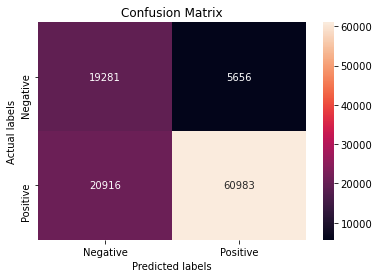

In [126]:
cm = confusion_matrix(y_train, glove_logr_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

Comparing confusion matrix shows overall worse performance with lower TP, TN and higher FP, FN. 

#### Random Forest with GloVe

In [96]:
glove_rf_model = Pipeline([
    ('glove',  W2vVectorizer(glove)),
    ('rf', rf)
])

glove_rf = cross_validate(glove_rf_model, X_train, y_train, cv = 5, 
                          scoring = ['precision_macro', 'recall_macro', 'f1_macro'])



model_results = model_results.append({'Model': 'glove_rf_model',
                      'mean f1_score': round(glove_rf['test_f1_macro'].mean(), 4),
                      'std f1_score': round(glove_rf['test_f1_macro'].std(), 4),
                      'mean precision': round(glove_rf['test_precision_macro'].mean(), 4),
                      'mean recall': round(glove_rf['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,Baseline_vader,0.6779,N/A,0.7374,0.6565
1,cv_logr_model,0.8445,0.0026,0.8368,0.8532
2,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
3,cv_rf_model,0.7974,0.0029,0.8771,0.7602
4,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
5,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
6,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580
7,w2v_logr_model,0.7873,0.0019,0.7683,0.8298
8,w2v_rf_model,0.7264,0.0032,0.8454,0.6909
9,glove_logr_model,0.7066,0.0016,0.6974,0.7589


As expected again this model performed poorly.

In [ ]:
glove_rf_hat = cross_val_predict(glove_rf_model, X_train, y_train, cv = 5)

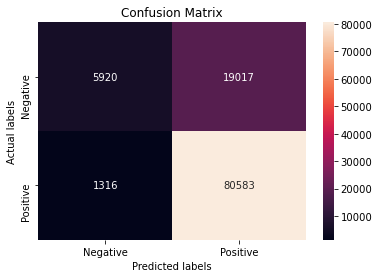

In [127]:
cm = confusion_matrix(y_train, glove_rf_hat)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

Similar to the performance of previous random forest models. This model predicts positive sentiment well with 80,583 TP and 1,316 FN, but suffers at predicting negative sentiment with only 5,920 TN and 19,017 FP.

Based on all the different iterations of models, random forest classifiers seem to perform poorly on the negative class. I can check if adjusting any hyper parameters can help remedy this in future analysis.

## Evaluating Final Model

Best model based on f1 score was found to be TF-IDF vectorizer with logistic regression.

In [98]:
tfidf_logr_model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvec',
                 TfidfVectorizer(min_df=10, ngram_range=(1, 2),
                                 preprocessor=<function dummy at 0x0000027BF5CC5940>,
                                 tokenizer=<function dummy at 0x0000027BF5CC5940>)),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [99]:
y_pred = tfidf_logr_model.predict(X_test)

In [130]:
print('f1: ' + str(f1_score(y_test, y_pred, average = 'macro')))
print('precision: ' + str(precision_score(y_test, y_pred, average = 'macro')))
print('recall: ' + str(recall_score(y_test, y_pred, average = 'macro')))
print('accuracy: '+ str(accuracy_score(y_test, y_pred)))

f1: 0.8511681738038521
precision: 0.8331699203967295
recall: 0.8772236175123104
accuracy: 0.8860726319730438


In [101]:
model_results[model_results.Model == 'tfidf_logr_model']

,Model,mean f1_score,std f1_score,mean precision,mean recall
4,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689


f1, precision, and recall scores are similar to our cross validation scores. This is a good sign that our model is not over fitting on the training data.

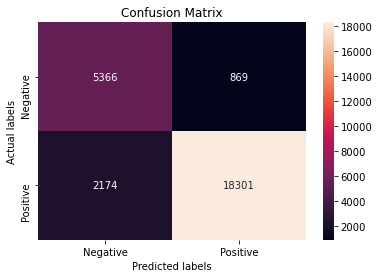

In [128]:
cm = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt = 'g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

On the test set, optimal model was able to predict 5,366 negative reviews correctly and 18,301 positive reviews correctly.

### Visualizing Important features

For logistic regression, a simple way to infer feature importance of the model would be to examine the coefficients assigned to each feature. Since this was modeled as a binary classification problem with negative being 0 and 1 being positive sentiment, positive scores indicate features that predicts class 1 and negative scores indicate features that predict class 0. We can then look for the highest positive and lowest negative features to find the top important words in each sentiment.

In [102]:
# grab coef from model
weights = tfidf_logr_model.steps[1][1].coef_[0]
weights

array([ 0.3670216 ,  0.06542156,  0.27658861, ..., -0.33114858,
       -0.4878942 ,  0.23740819])

In [103]:
# grab feature names
features = tfidf_logr_model['tfidfvec'].get_feature_names()

In [104]:
# concat them to a dataframe
feature_importance = pd.DataFrame({'words': features, 'weights': weights})

In [105]:
# top positive features
top_pos = feature_importance.sort_values('weights', ascending = False).head(25)

In [106]:
# bottom negative features
top_neg = feature_importance.sort_values('weights', ascending = True).head(25)

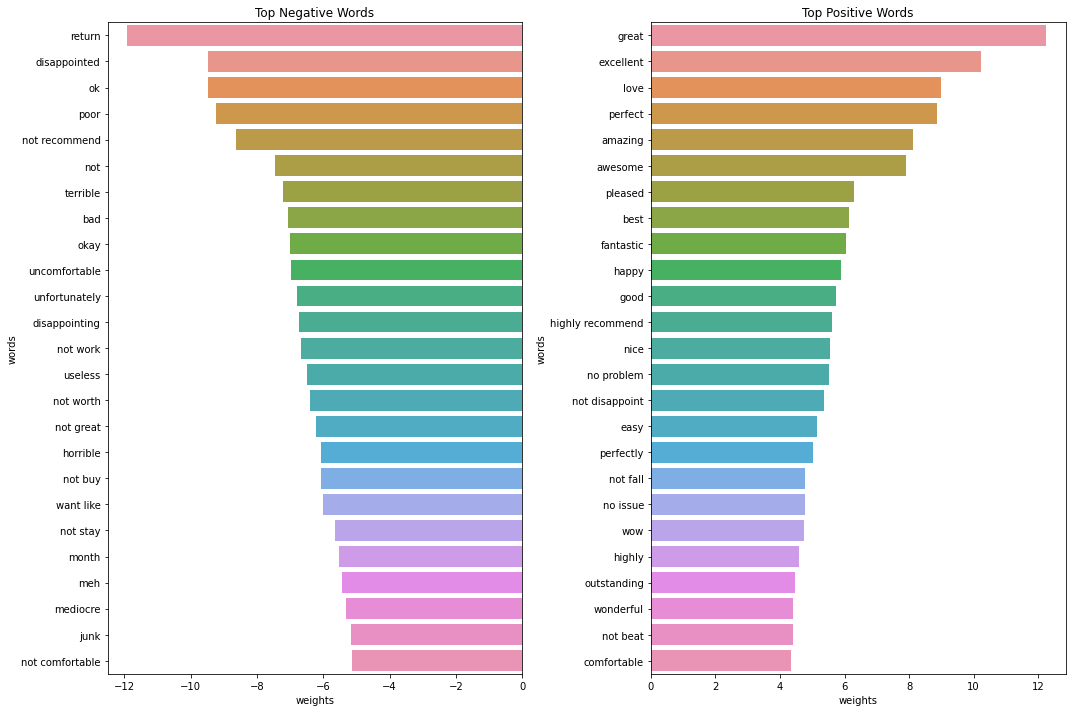

In [107]:
fig, axs = plt.subplots(1,2, figsize=(15,10))

sns.barplot(data = top_neg, x = 'weights', y = 'words', orient = 'h', ax = axs[0])
sns.barplot(data = top_pos, x = 'weights', y = 'words', orient = 'h', ax = axs[1])

axs[0].set_title('Top Negative Words')
axs[1].set_title('Top Positive Words')

fig.tight_layout();

Top positive words show general satisfaction from the reviews. Top Negative words show dissatisfaction, with the most negative score associated with the word return. Which indicates that customers generally dissatisfied with the product would want a refund instead of continuing use.

## Conclusion

Analyzing product reviews can help get a better sense of the market. Based on my this project we are able to identify meaningful insights of what customers think about certain products. Reviews related to comfort and sound quality make up around 60% of the total reviews in this data. 

Comfort, the topic with the most reviews, also has the highest percent of negative reviews. Which makes sense as people come in all different sizes and shapes, it is very difficult for any one product to fit comfortably on everyone.

Interstingly the second most popular topic, sound quality, has the highest percent of positive reviews. 

Through this project I was able to confirm that products with higher ratings generally have a higher positive sentiment and  products with lower ratings generally have a negative sentiment. 

## Recommendations

* <b>Focus on customizable comfort</b> - Comfort was found to be the most popular topic disscussed in product reviews, it also contained the highest percent of negative reviews with one of the top negatively associated word found to be uncomfortable. Providing changable earbud plugs or head phone cushions can help improve comfort of product no matter the customer.

* <b>Improve Customer service</b> - The second highest percent of negative reviews was found to be associated with customer service. A few of the top terms associated with the topic were "send replacement", "warranty", "feedback", "update review". Addressing specific issues raised by customers or making broader changes can improve overall satisfaction.

* <b>Adjust Marketing Strategies</b> - Battery / Connectivity was found to have higher negative sentiment compared to design or sound quality. Focusing on marketing products with longer battery life or more stable bluetooth connections can help address customers that feel negatively towards this topic.

## Limitations

Due to the nature of Amazon reviews, they are unable to be an exact representation of the overall market:

* Companies may offer discounts or free product for high reviews or there can be a high amount of fake reviews generated by algorithms.

* Only the most vocal will be heard, there are many customers that will like or dislike a product but not leave reviews.

Other limitations deal with my processing of text data.

* Best model was found to be TF-IDF vectorizer with logistic regression, however this method only focuses on term frequency. It is unable to capture semantic relationship between words.

* My text cleaning methods did not address words with typos or nonsensical words, with may lead to increased feature dimensionaltiy during training and effect results.

## Next Steps

* Try different methods for topic modeling, such as Top2Vec. LDA works by assuming that each document is generated by a random process involving the selection of topics and words from those topics. Top2Vec, on the other hand, is a neural network-based method that clusters similar documents and identifies representative topics, which can help to better capture semantic relationships between words.

* Make use of recurrent neual network with LSTM for classification. 

* Try aspect based sentiment analysis.

## Word Cloud for Presentation

Creating wordcloud based on weights found by best model. WordCloud can be customized to use specified weights instead of frequency.

Examining most important words the model found that helps classify positive sentiment.

In [109]:
pos_words = feature_importance[feature_importance.weights > 0].copy()

Extracting all positive weights from feature_importance dataframe

In [110]:
# create dictionary of words and their weights
word_weights = dict(zip(pos_words.words, pos_words.weights))

Converted names and weights of features into a dictionary for word cloud input.

In [111]:
wordcloud = WordCloud(background_color='white',
                      colormap='tab20',
                      width=1600, 
                      height=800, ).generate_from_frequencies(word_weights)

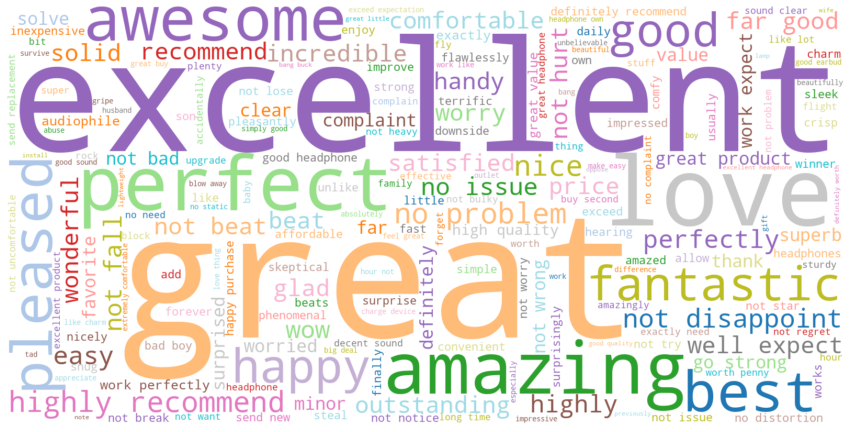

In [112]:
fig, ax = plt.subplots(figsize = (15,10))


ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');

Word cloud output matches above barplot of more important features, with the top 5 positive features easily readable. (great, excellent, love, perfect, amazing)

Examining most important words the model found that helps classify negative sentiment.

In [113]:
neg_words = feature_importance[feature_importance.weights <= 0].copy()

Changing weights to absolute values as lower valued weights represent more negative words 

In [114]:
neg_words.weights = neg_words.weights.abs()

Converting names and weights of features into a dictionary for word cloud input.

In [115]:
neg_word_weights = dict(zip(neg_words.words, neg_words.weights))

In [116]:
neg_wordcloud = WordCloud(background_color='black', 
                          colormap='Set2',
                          width=1600, 
                          height=800).generate_from_frequencies(neg_word_weights)

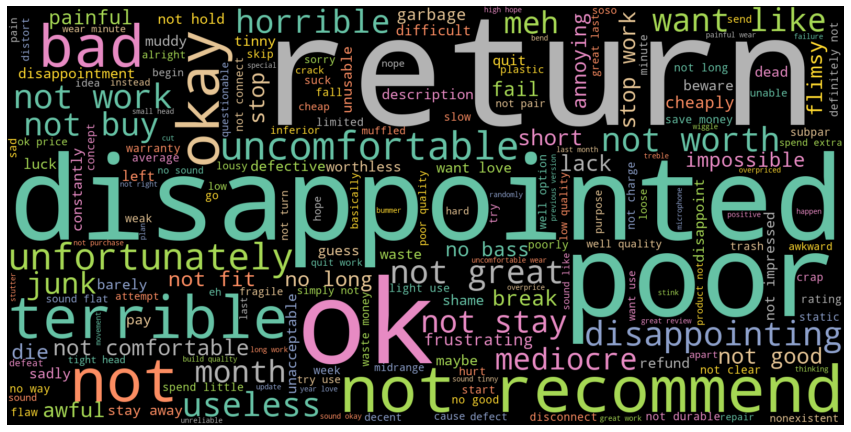

In [117]:
fig, ax = plt.subplots(figsize = (15,10))


ax.imshow(neg_wordcloud, interpolation='bilinear')
ax.axis('off');

Word cloud output matches above barplot of more important features, with the top 5 features easily readable. (retuen, dissappointed, ok, poor, not recommend)